# TP Metric learning



In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from scipy import stats

For this lab, we will use the [MNIST dataset (~15Mo)](https://en.wikipedia.org/wiki/MNIST_database). It consists of 28x28 images (loaded as a 784 vector) and the associated label for training, validation and test sets. 

The following code loads a subset of 1000 training samples and 500 validation samples.

5


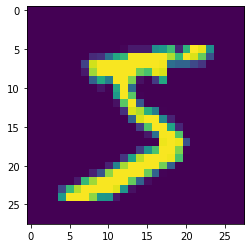

In [ ]:
# Load the dataset
data = np.load('mnist1k.npz')
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_train_bin = data['X_train_bin']
y_train_bin = data['y_train_bin']
X_val_bin = data['X_val_bin']
y_val_bin = data['y_val_bin']
N_train = len(y_train)
N_val = len(y_val)
plt.imshow(X_train[0,:].reshape(28,28))
print(y_train[0])

## Implementing a $k$Nearest-Neighbor

#### Q1. Implement a class that encapsulate the squared euclidean distance ($\| x_1 - x_2 \|^2$) using the Distance parent class.


In [ ]:
class Distance():
    '''
    trains this distance function on a training set
    '''
    def fit(self, X, y):
        pass
    
    '''
    returns the distance between the sets X1 and X2:
    X1 is n x d (n samples of dimension d)
    X2 is m x d (n samples of dimension d)
    output is n x m (distance matrix)
    '''
    def predict(self, X1, X2):
        pass

In [ ]:
class L2Distance(Distance):
    def __init__(self):
        super().__init__()
    
    def predict(self, X1, X2):
        X1_norm=jnp.linalg.norm(X1,ord=None,axis=1)
        X2_norm=jnp.linalg.norm(X2,ord=None,axis=1)

        scalar_product=jnp.dot(X2,X1.T)
        X1_norm=X1_norm[None,:]
        X2_norm=X2_norm[:,None]
        return X1_norm**2+X2_norm**2-2*scalar_product



Q2. Implement a $k$NearestNeighbor class that relies on a Distance object to find the neighbors. It also trains the distance (by default, does nothing).

In [ ]:

class KNN():
    def __init__(self, distance, k=1,X=None,y=None):
        self.distance = distance
        self.k = k
        self.X=None
        self.y=None
    
    '''
    trains the distance and memorizes the training set
    X: n x d (n samples of dimension d)
    y: n (n labels)
    '''
    def fit(self,X,y):
        self.X=X
        self.y=y
        self.distance.fit(X,y)
        
        
    
    '''
    predict the set of samples
    '''
    def predict(self, x):
      dist=self.distance.predict(self.X,x)
      indices=jnp.argsort(dist,axis=1) 
      y1=self.y[indices[:,:self.k]]
      yp= stats.mode(y1,axis=1).mode[:,0]

      return yp

We first try on the reduced training set to check that our code works. 

In [ ]:
knn = KNN(L2Distance(), k=3)
knn.fit(X_train, y_train)
y_hat = knn.predict(X_train)
err = (y_hat != y_train).mean()
print('training error {}'.format(err))
y_hat = knn.predict(X_val)
err = (y_hat != y_val).mean()
print('val error {}'.format(err))

training error 0.075
val error 0.162


#### Q3. Implement a trainable $\ell_2$ distance function relying. I performs a linear projection $P$ such that the distance between similar samples is minimized, trained using gradient descent

$$ \min_P \sum_{x, x_p, y = y_p} \|Px - Px_p\|^2 $$

In [ ]:
class L2MinDistance(Distance):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.P = np.random.randn(input_dim, output_dim)/jnp.sqrt(input_dim+output_dim)
        self.dist = L2Distance()
    
    @staticmethod
    def loss(P, X, y, dist):
      P_x=jnp.matmul(X,P)

      Matrix_dist=dist(P_x,P_x)
      equal_y=(y[None,:]==y[:,None])


      return jnp.mean(Matrix_dist*equal_y,axis=[0,1])

    
    @staticmethod
    def update(P, X, y, dist, eta=0.01):
        l, dp = jax.value_and_grad(L2MinDistance.loss, argnums=0)(P, X, y, dist)
        return l, P - eta*dp
        
    def fit(self, X, y):
        loss = []

        for i in range(1000):
            
            l, self.P = L2MinDistance.update(self.P, X, y, self.dist.predict)
            loss.append(l)
            print(l)
        plt.plot(loss)
        return
    
    def predict(self, X1, X2):
      
      Px_1=jnp.matmul(X1,self.P)
      Px_2=jnp.matmul(X2,self.P)
      return self.dist.predict(Px_1,Px_2)
              
        

0.6239003
0.6187037
0.6135877
0.6085504
0.6035902
0.5987059
0.59389615
0.58915913
0.584493
0.5798976
0.5753704
0.5709109
0.56651735
0.56218874
0.5579236
0.5537211
0.5495795
0.54549825
0.54147553
0.5375111
0.5336032
0.52975076
0.52595323
0.52220917
0.5185178
0.5148779
0.511289
0.50774986
0.5042595
0.50081694
0.49742168
0.49407277
0.4907689
0.48750997
0.4842946
0.48112223
0.47799203
0.4749035
0.47185555
0.4688478
0.46587926
0.46294925
0.46005717
0.45720246
0.4543846
0.45160225
0.4488553
0.4461433
0.44346547
0.44082105
0.43820965
0.43563077
0.4330836
0.430568
0.42808285
0.42562836
0.4232032
0.42080778
0.41844085
0.41610226
0.41379154
0.41150826
0.40925187
0.4070219
0.40481776
0.40263957
0.4004864
0.3983581
0.3962543
0.39417437
0.392118
0.3900849
0.38807467
0.3860871
0.38412145
0.3821778
0.38025552
0.37835428
0.3764739
0.37461403
0.37277415
0.37095442
0.36915377
0.36737278
0.36561036
0.36386707
0.3621417
0.36043468
0.3587453
0.3570737
0.35541934
0.35378173
0.3521611
0.35055697
0.3489691
0.

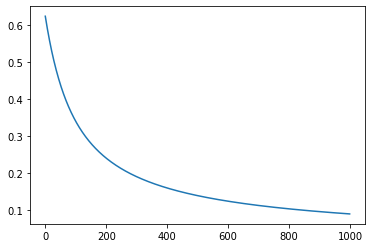

In [ ]:
knn = KNN(L2MinDistance(784, 64), k=3)
knn.fit(X_train, y_train)
y_hat = knn.predict(X_train)
err = (y_hat != y_train).mean()
print('training error {}'.format(err))
y_hat = knn.predict(X_val)
err = (y_hat != y_val).mean()
print('val error {}'.format(err))

Les résultats de cette projection ne sont pas bons car l'algorithme va projetter tout les points au même endroit, cela va empêcher de bien généraliser cet algorithme. Il est donc nécessaire d'éloigner les pooints qui possèdent des labels différents.  

## Contrastive loss

Next, we want to mitigate the tendancy of only minimizing the distance to collapse all samples to the same location

#### Q3. Code a trainable distance function that minimizes the distance between related samples up to a margin and maximizes the distance between unrelated samples up to a margin

$$\min_p \sum_{x, x_p, y = y_p} \max(0, \|Px - Px_p\|^2 - \alpha) - \lambda \sum_{x, x_p, y \neq y_p} \max(0, \beta - \|Px - Px_p\|^2) $$

Plot the loss value as the gradient descent progresses

In [ ]:
class L2ContrastiveDistance(Distance):
    def __init__(self, input_dim, output_dim, alpha=0.1, beta= 0.7, lambd=0.5):
        super().__init__()
        self.P = np.random.randn(input_dim, output_dim)/jnp.sqrt(input_dim+output_dim)
        self.dist = L2Distance()
        self.alpha = alpha
        self.beta = beta
        self.lambd = lambd
    
    @staticmethod
    def loss(P, X, y, alpha, beta, lambd, dist):
        P_x=jnp.matmul(X,P)
        
        Matrix_dist=dist(P_x,P_x)
        Matrix_dist_1=Matrix_dist-alpha
        equal_y=(y[None,:]==y[:,None])
        
        first_part=equal_y*jnp.max(Matrix_dist_1,0)
        
        different_y=(y[None,:]!=y[:,None])
        Matrix_dist_2=beta-Matrix_dist
        second_part=different_y*jnp.max(Matrix_dist_2,0)
        
        return np.mean(first_part-lambd*second_part,axis=[0,1])

    
    @staticmethod
    def update(P, X, y, alpha, beta, lambd, dist, eta=0.05):
        l, dp = jax.value_and_grad(L2ContrastiveDistance.loss, argnums=0)(P, X, y, alpha, beta, lambd, dist)
        return l, P - eta*dp
        
    def fit(self, X, y):
        loss = []
        for i in range(10):
            l, self.P = L2ContrastiveDistance.update(self.P, X, y, self.alpha, self.beta, self.lambd, self.dist.predict)
            loss.append(l)
        plt.plot(loss)
        return
    
    def predict(self, X1, X2):
      Px_1=jnp.matmul(X1,self.P)
      Px_2=jnp.matmul(X2,self.P)
      return self.dist.predict(Px_1,Px_2)
        

training error 0.147
val error 0.374


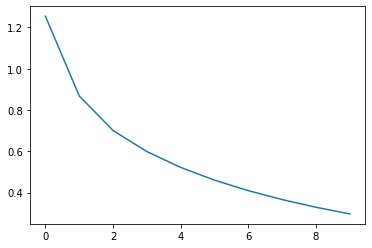

In [ ]:
knn = KNN(L2ContrastiveDistance(784, 64), k=3)
knn.fit(X_train, y_train)
y_hat = knn.predict(X_train)
err = (y_hat != y_train).mean()
print('training error {}'.format(err))
y_hat = knn.predict(X_val)
err = (y_hat != y_val).mean()
print('val error {}'.format(err))

En pénalizant le fait que les points qui n'ont pas le même label se rapproche, on arrive à améliorer les résultats et à rendre notre prédiction plus généraisable. L'overfitting est très important dès que le nombre d'itération augmente. 



## Triplet loss

Since $k$NN is in nature using a ranking approach by sorting the samples, we will know consider a loss function that enforces the order of the samples rather than their absolute distance values.

$$ \min_P \sum_{x, x_p, x_n, y = y_p, y \neq y_n} \max(0, \alpha + \|x - x_p\|^2 - \|x - x_n\|^2) $$

#### Q4. Code the triplet loss based trainable distance function.

In [ ]:
class L2TripletDistance(Distance):
    def __init__(self, input_dim, output_dim, alpha=0.3):
        super().__init__()
        self.P = np.random.randn(input_dim, output_dim)/jnp.sqrt(input_dim+output_dim)
        self.dist = L2Distance()
        self.alpha = alpha
    
    @staticmethod
    def loss(P, X, y, alpha, dist):
        P_X = jnp.matmul(X, P)
        D1 = dist(P_X, P_X)
        D = (D1[:,:,None] - D1[:,None,:] + alpha)
        D = jnp.max(D,0)
        T_ = (y[:,None] == y[None,:])
        F_ = (y[:,None] != y[None,:])
        Sum = (D * T_[:,:,None] * F_[:,None,:]).mean()
        return Sum
    
    @staticmethod
    def update(P, X, y, alpha, dist, eta=0.05):
        l, dp = jax.value_and_grad(L2TripletDistance.loss, argnums=0)(P, X, y, alpha, dist)
        return l, P - eta*dp
        
    def fit(self, X, y):
        loss = []
        for i in range(10):
            
            l, self.P = L2TripletDistance.update(self.P, X, y, self.alpha, self.dist.predict)
            loss.append(l)
        plt.plot(loss)
        return
    
    def predict(self, X1, X2):
        P_x1 = jnp.matmul(X1, self.P)
        P_x2 = jnp.matmul(X2, self.P)
        D = self.dist.predict(P_x1, P_x2)
        return D    

training error 0.269
val error 0.42


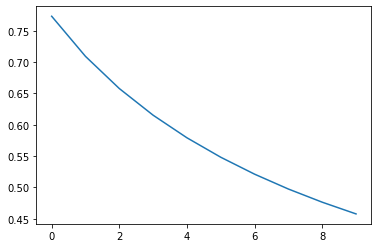

In [ ]:
knn = KNN(L2TripletDistance(784, 64), k=3)
for k in range((len(X_train)-500)//500):
  knn.fit(X_train[500*k:500*(k+1)], y_train[500*k:500*(k+1)])
y_hat = knn.predict(X_train)
err = (y_hat != y_train).mean()
print('training error {}'.format(err))
y_hat = knn.predict(X_val)
err = (y_hat != y_val).mean()
print('val error {}'.format(err))

Le résultat est moins bon qu'avec les autres distances, on en conclut que ce mode ne permet pas de mieux séparer les points qui ne sont pas ensemble. On utilisera donc la précédente méthode pour faire la cross-validation. 

#### Q5. Perform a cross validation on the margin, the number of dimensions and the number of neighbors.

In [ ]:
def randomSplit(key, X, y, train_part=0.8):
    n = X.shape[0]
    n_train = int(train_part*n); n_test = n - n_train
    p = jax.random.permutation(key, n)
    X_train = X[p[0:n_train], :]
    y_train = y[p[0:n_train]]
    X_val = X[p[n_train:],:] 
    y_val = y[p[n_train:]]
    return X_train, y_train, X_val, y_val

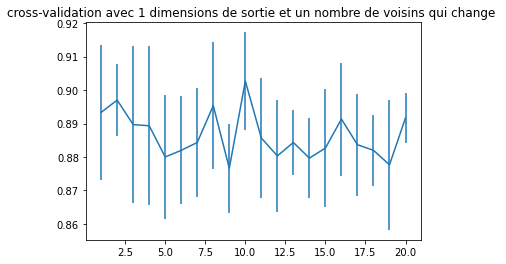

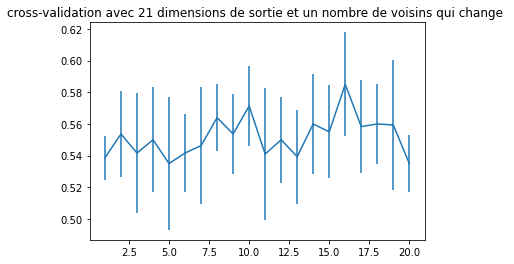

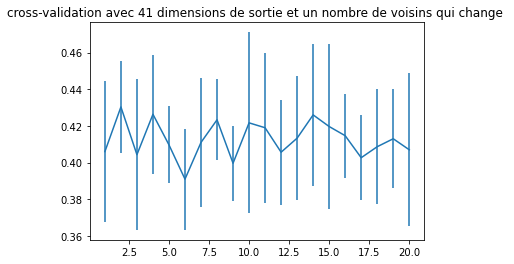

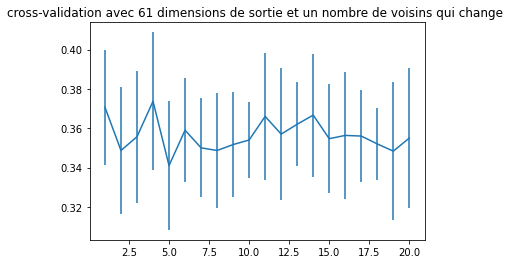

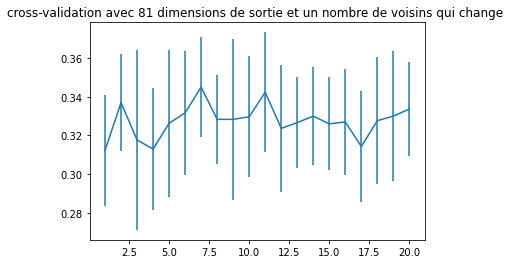

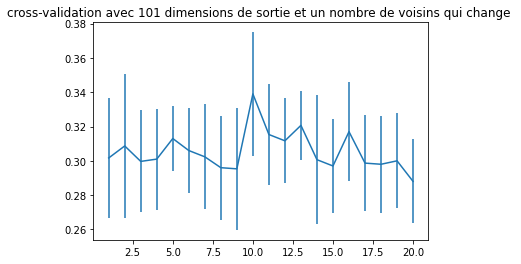

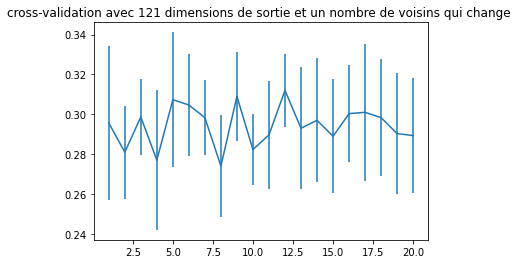

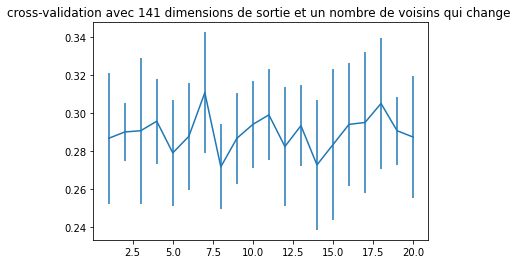

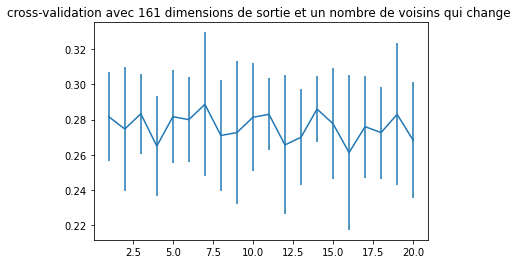

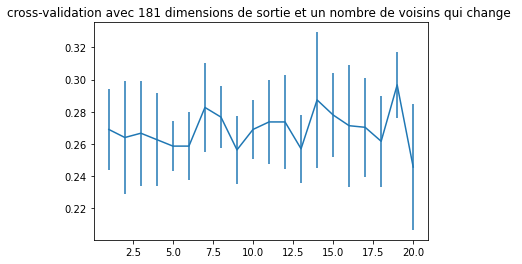

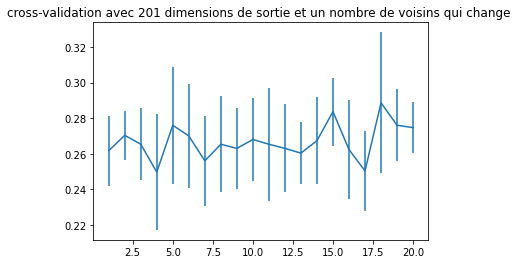

In [ ]:
key = jax.random.PRNGKey(32)
import random 
for dim in range(1,202,20):
  mean = []
  std=[]
  for k in range(1, 21):
      lk = []
      for s in range(10):
          key, skey = jax.random.split(key)
          X_train, y_train, X_val, y_val = randomSplit(skey, np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))
          knn = KNN(L2ContrastiveDistance(784,dim), k=3)      

          indices = np.arange(X_train.shape[0])
          np.random.shuffle(indices)
          X_train=X_train[indices]
          y_train=y_train[indices]

          for k in range(len(X_train)//500-1):
            knn.fit(X_train[500*k:500*(k+1)], y_train[500*k:500*(k+1)])
          y_hat = knn.predict(X_val)
          lk.append((y_hat != y_val).mean())
      mean.append(sum(lk)/len(lk))

      std.append(np.std(lk))

  plt.clf()
  plt.errorbar(range(1,21), mean,std)
  plt.title("cross-validation avec "+str(dim)+" dimensions de sortie et un nombre de voisins qui change ")
  plt.show()

On remarque ainsi que pour un nombre de voisins environ égale à 13, on minimise l'erreur globale. l'augmentation du nombre de dimensions est important pour réduire l'erreur globale car on perd de l'information au fur et à mesure. Il faut cependant choisir entre précision et stockage nécessaire

## visualization

In order to visualize what is happening during the metric learning, we can interpret the projections of $P$ as images.

#### Q6. Extract the projection from a trained distance and plot each projector associated with each output space component as an image.

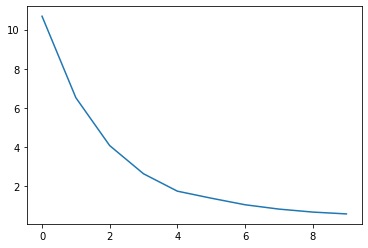

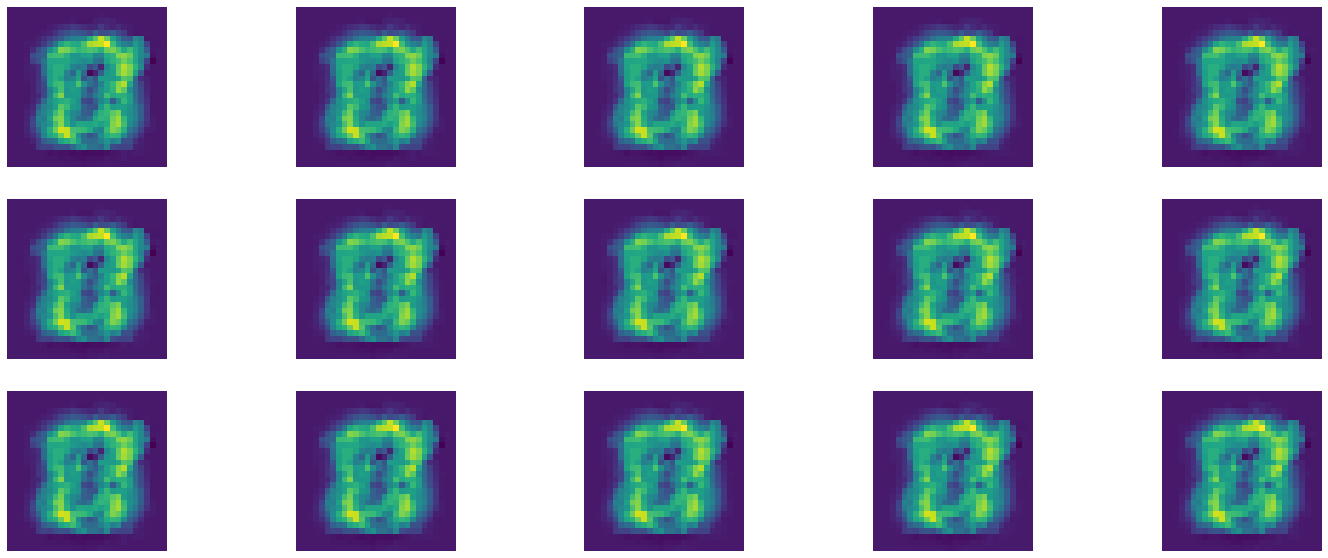

In [ ]:
output = 40
knn = L2TripletDistance(784,output)
knn.P  = (jnp.ones((784, output)) * jnp.linspace(-1,1,output)/jnp.sqrt(784+output)).astype(jnp.float16)
indices = np.arange(X_train.shape[0])
X_train=X_train[indices]
y_train=y_train[indices]
for k in range(len(X_train)//500-1):
  knn.fit(X_train[500*k:500*(k+1)], y_train[500*k:500*(k+1)])
P = np.array(knn.P).astype(np.float32)

fig, ax = plt.subplots(int(output/5), 5, figsize=(25, 10))
for k in range(output):
  img = P[:,k].reshape(28,28)
  ax[k//5][k%5].imshow(img)
  ax[k//5][k%5].axis('off')

On remarque que l'on a seulement deux types de projecteurs qui nous permettent de discriminer les différentes possibilités pour cette base de données.On voit que les pixels sur les côtés sont exclus de la projection.